# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**

In [ ]:
%pip install tensorflow==1.15.0

In [ ]:
%pip install innvestigate

In [ ]:
%pip install deeplift

# Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os
import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.15.0
2.2.4


# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [3]:
#train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
#test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
#val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

train = get_training_data('../data/train')
test = get_training_data('../data/test')
val = get_training_data('../data/val')

OpenCV(4.1.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Data Visualization & Preprocessing

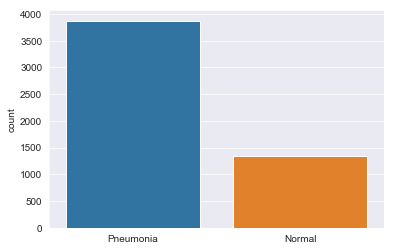

In [4]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

Text(0.5, 1.0, 'NORMAL')

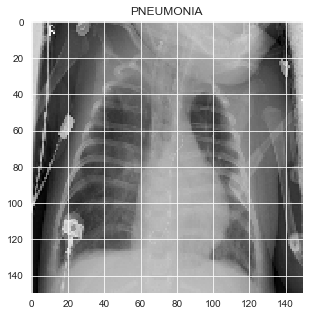

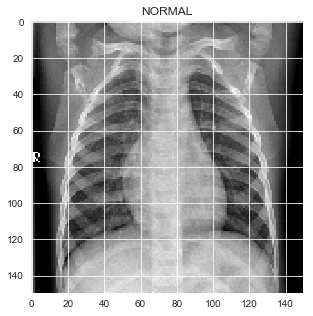

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [7]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [8]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [9]:
def create_preprocessing_f(X, input_range=[0, 1]):
    """
    Generically shifts data from interval [a, b] to interval [c, d].
    Assumes that theoretical min and max values are populated.
    """

    if len(input_range) != 2:
        raise ValueError(
            "Input range must be of length 2, but was {}".format(
                len(input_range)))
    if input_range[0] >= input_range[1]:
        raise ValueError(
            "Values in input_range must be ascending. It is {}".format(
                input_range))

    a, b = X.min(), X.max()
    c, d = input_range

    def preprocessing(X):
        # shift original data to [0, b-a] (and copy)
        X = X - a
        # scale to new range gap [0, d-c]
        X /= (b-a)
        X *= (d-c)
        # shift to desired output range
        X += c
        return X

    def revert_preprocessing(X):
        X = X - c
        X /= (d-c)
        X *= (b-a)
        X += a
        return X

    return preprocessing, revert_preprocessing

In [10]:
input_range = [-1, 1]
preprocess, revert_preprocessing = create_preprocessing_f(x_train, input_range)

In [11]:
data = (
    preprocess(x_train), y_train,
    preprocess(x_val), y_val
)

In [12]:
num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# Training the Model

In [13]:
'''
model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tensorflow.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    tensorflow.keras.layers.Dropout(0.1),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tensorflow.keras.layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tensorflow.keras.layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tensorflow.keras.layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.BatchNormalization(),
    tensorflow.keras.layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    tensorflow.keras.layers.Flatten(),
    tensorflow.keras.layers.Dense(units = 128 , activation = 'relu'),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.Dense(units = 2 , activation = 'softmax')
])
'''

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 1)),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(2, activation="softmax"),
])


model.compile(optimizer = "rmsprop" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 341056)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               174621184 
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 174,641,026
Trainable params: 174,641,026
Non-trainable params: 0
________________________________________________________

In [14]:
history = history = model.fit(data[0], keras.utils.to_categorical(data[1], num_classes),
                        batch_size=128,
                        epochs=1,
                        validation_data = (data[2], keras.utils.to_categorical(data[3], num_classes)),
                        #callbacks=[learning_rate_reduction],
                        verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5216 samples, validate on 16 samples
Epoch 1/1





5216/5216 [==============================] - 238s 46ms/step - loss: 4.0527 - acc: 0.7375 - val_loss: 8.0590 - val_acc: 0.5000


In [15]:
print("Loss of the model is - " , model.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes))[0])
print("Accuracy of the model is - " , model.evaluate(x_test, keras.utils.to_categorical(y_test, num_classes))[1]*100 , "%")

624/624 [==============================] - 6s 10ms/step
Loss of the model is -  6.044285872043708
624/624 [==============================] - 8s 13ms/step
Accuracy of the model is -  62.5 %


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = history = model.fit(x_train, y_train,
                        batch_size=64,
                        epochs=1,
                        validation_data = (x_val, y_val),
                        callbacks=[learning_rate_reduction],
                        verbose=1)

In [ ]:
#history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 2 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

# Analysis after Model Training

In [ ]:
#epochs = [i for i in range(12)]
epochs = [i for i in range(2)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [16]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.62      1.00      0.77       390
   Normal (Class 1)       0.00      0.00      0.00       234

           accuracy                           0.62       624
          macro avg       0.31      0.50      0.38       624
       weighted avg       0.39      0.62      0.48       624



In [18]:
cm = confusion_matrix(y_test,predictions)
cm

array([[390,   0],
       [234,   0]])

In [19]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

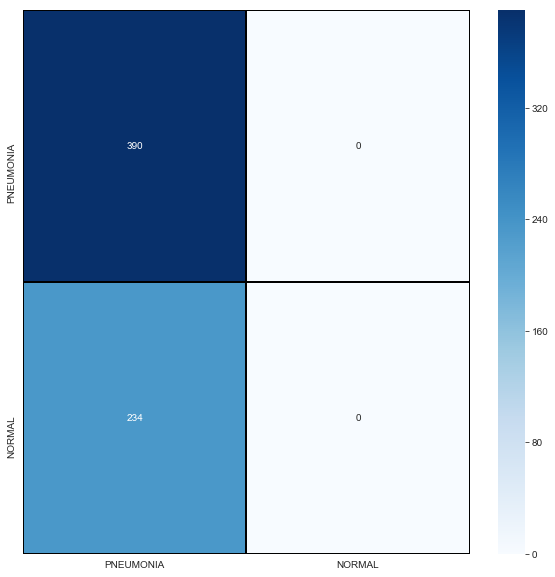

In [20]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [21]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

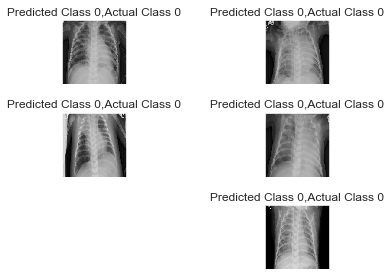

In [22]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

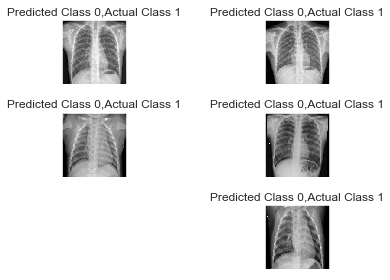

In [23]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [24]:
def postprocess(X):
    X = X.copy()
    X = iutils.postprocess_images(X)
    return X


def bk_proj(X):
    return ivis.graymap(X)


def heatmap(X):
    return ivis.heatmap(X)


def graymap(X):
    return ivis.graymap(np.abs(X))

In [44]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    #return revert_preprocessing(X) / 255
    return revert_preprocessing(X)

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),

    # Signal
    ("deconvnet",             {},                       bk_proj,        "Deconvnet"),
    ("lrp.z",                 {},                       heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           heatmap,        "LRP-Epsilon"),
]

In [45]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                            model_wo_softmax, # model without softmax output
                                            **method[1])      # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=256, verbose=1)
    analyzers.append(analyzer)

In [46]:
n = 10
test_images = list(zip(data[2][:n], data[3][:n]))

analysis = np.zeros([len(test_images), len(analyzers), 150, 150, 3])
text = []


for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    presm = model_wo_softmax.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()
    
    # Save prediction info:
    text.append(("%s" % label_to_class_name[y],    # ground truth label
                 "%.2f" % presm.max(),             # pre-softmax logits
                 "%.2f" % prob.max(),              # probabilistic softmax output  
                 "%s" % label_to_class_name[y_hat] # predicted label
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x)
        
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = postprocess(a)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
        # Store the analysis.
        analysis[i, aidx] = a[0]

In [47]:
def plot_image_grid(grid,
                    row_labels_left,
                    row_labels_right,
                    col_labels,
                    file_name=None,
                    figsize=None,
                    dpi=224):
    n_rows = len(grid)
    n_cols = len(grid[0])
    if figsize is None:
        figsize = (n_cols, n_rows+1)

    plt.clf()
    plt.rc("font", family="sans-serif")

    plt.figure(figsize=figsize)
    for r in range(n_rows):
        for c in range(n_cols):
            ax = plt.subplot2grid(shape=[n_rows+1, n_cols], loc=[r+1, c])
            # TODO controlled color mapping wrt all grid entries,
            # or individually. make input param
            if grid[r][c] is not None:
                ax.imshow(grid[r][c], interpolation='none')
            else:
                for spine in plt.gca().spines.values():
                    spine.set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

            # column labels
            if not r:
                if col_labels != []:
                    ax.set_title(col_labels[c],
                                 rotation=22.5,
                                 horizontalalignment='left',
                                 verticalalignment='bottom')

            # row labels
            if not c:
                if row_labels_left != []:
                    txt_left = [l+'\n' for l in row_labels_left[r]]
                    ax.set_ylabel(
                        ''.join(txt_left),
                        rotation=0,
                        verticalalignment='center',
                        horizontalalignment='right',
                    )

            if c == n_cols-1:
                if row_labels_right != []:
                    txt_right = [l+'\n' for l in row_labels_right[r]]
                    ax2 = ax.twinx()
                    ax2.set_xticks([])
                    ax2.set_yticks([])
                    ax2.set_ylabel(
                        ''.join(txt_right),
                        rotation=0,
                        verticalalignment='center',
                        horizontalalignment='left'
                    )

    if file_name is None:
        plt.show()
    else:
        print('Saving figure to {}'.format(file_name))
        plt.savefig(file_name, orientation='landscape', dpi=dpi)

<Figure size 432x288 with 0 Axes>

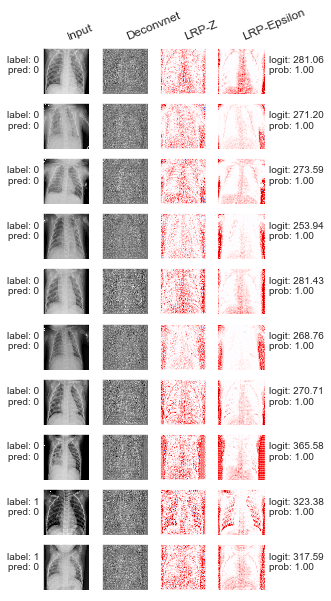

In [48]:
EXPLAIN_PATH = os.path.join("../images/grid.png")

grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'pred: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                       file_name=os.environ.get("PLOTFILENAME", None))